# Projet Anévrisme : Un bref compte-rendu

## Création du Domaine de Travail

On commence par importer les packages nécessaires.

In [50]:
import numpy as np                       #Package d'éléments mathématiques
import scipy.sparse.linalg as sci        #Package d'éléments mathématiques
import matplotlib.pyplot as plt          #Construction des grpahiques
from mpl_toolkits.mplot3d import Axes3D  #Graphiques 3D
from math import pi                      #Le nombre pi

Le code suivant permet la création du domaine initial représentant un anévrisme. Il est composé de façon binaire où les 1 représentent la frontière du domaine. 

Les paramètres sont :
- N : Le nombre d'intervalles du maillage
- ray_tub : La largeur des artères
- R : Le rayon du cercle représentant l'anévrisme
- Hg et Hb : Pourcentage entre 5% (en haut) et 95% (en bas) de la hauteur des artères verticales par rapport au haut du domaine
- Lb : La longueur de l'artère du bas
- angle : La valeur de l'angle, en degré, entre les 2 dernières artères.

De nombreux commentaires sont disponibles pour faciliter la compréhension de notre démarche.

In [51]:
def Dom_init(N, ray_tub, R, Hg, Hd, Lb, angle):
    """Retourne la géométrie initiale représentant un anévrisme avec N le nombre d'intervalles ;
    ray_tub le rayon des artères; R le rayon du sac anévrismal; Hg et Hd la hauteur des artères verticales
    Lb la longueur de l'artère du bas; angle l'anlge entre les 2 dernières artères"""

    #Définition du maillage. On choisit de découper le segment [0,1] en N intervalles. 
    #Ce qui donne un problème de taille (N+1)*(N+1).
    #Prendre de préférance un N pair (pour assurer (N/2) entier).
    
    x = np.linspace(0,1,N+1)
    y = np.linspace(0,1,N+1)   

    #Définition de la matrice de taille (N+1)*(N+1).
    MAT = np.zeros((N+1,N+1))
    
    
    # Construction du "sac anévrismal" centré dans le maillage et de rayon R. 
    #Ici on part du centre du maillage et on parcourt les points dans le cadran inférieur gauche.
    #On détermine les points du cercle selon la méthode suivante : si un point est dans le cercle 
    #et que celui en dessous OU à gauche est à l'extérieur alors c'est un point frontière.
    #On retire les 0 en faisant une boucle if elif
    #On complète par symétrie pour les autres cadrans.
   
    i = int(N/2)
    j = int(N/2)
    
    while (x[i]-0.5)**2 + (y[j]-0.5)**2 <= R**2:
        while (x[i]-0.5)**2 + (y[j]-0.5)**2 <= R**2:
            if j <= int(N/2) and j >= int(N/2) - ray_tub :
                MAT[i][j] = 0
                MAT[N-i][N-j] = 0
                MAT[i][N-j] = 0
                MAT[N-i][j] = 0
            elif (x[i-1]-0.5)**2 + (y[j]-0.5)**2 >= R**2 or (x[i]-0.5)**2 + (y[j-1]-0.5)**2 >= R**2:
                MAT[i][j] = 1
                MAT[N-i][N-j] = 1
                MAT[i][N-j] = 1
                MAT[N-i][j] = 1
            j = j-1
        i = i-1
        j = int (N/2)
    
    # Construction de l'artère verticale "haute" de rayon d.
    j = N
    i = int(N/2)
    
    while (x[i-ray_tub]-0.5)**2 + (y[j]-0.5)**2 >= R**2:
        MAT[j][i-ray_tub] = 1
        MAT[j][i+ray_tub] = 1
        j = j-1
    
    #Construction de l'artère horizontale gauche "haute" repérée grâce au 
    #paramètre Hg (pourcentage avec 5 en haut et 95 en bas) de rayon d.
    #On retire également les 0.
    
    y_g = 1 - (0.5-R)*Hg/100
    k = N
    
    while y[k] >= y_g :
        k = k - 1
    
    for i in range(int(N/2)-ray_tub):
        MAT[k-ray_tub][i] = 1
        MAT[k+ray_tub][i] = 1

    for r in range(k - ray_tub+1, k + ray_tub):
        MAT[r][int(N/2)-ray_tub] = 0
    

    #Construction de l'artère horizontale droite "haute" repéré grâce au 
    #paramètre Hd (compris entre 5 (tout en haut) et 95 (tout en bas)) de rayon d.
    #On parcourt en "sens inverse" i.e en partant de la droite d'où la valeur N-i.
    #On retire également les 0.
    
    y_d = 1-(0.5-R)*Hd/100
    k = N
    
    while y[k] > y_d :
        k = k - 1
    
    for i in range(int(N/2)-ray_tub):
        MAT[k-ray_tub][N-i] = 1
        MAT[k+ray_tub][N-i] = 1

    for r in range(k - ray_tub+1, k + ray_tub):
        MAT[r][int(N/2)+ray_tub] = 0

    #Construction de l'artère verticale "basse" de rayon d et de longueur Lb.
    j = 0
    i = int(N/2)
    
    while (x[i-ray_tub]-0.5)**2 + (y[j]-0.5)**2 > R**2:
        if y[j] >= 0.5 - R - Lb :
            MAT[j][i-ray_tub] = 1
            MAT[j][i+ray_tub] = 1
        j=j+1
        

    #Construction des artères obliquent d'angle "angle" 
    #(degré compris entre 5 et 85) par rapport à la verticale x = N/2

    i = int(N/2)- ray_tub
    j = 0

    théta = (angle*pi)/180
    while MAT[j][i] == 0:
        j = j + 1
        
    b = y[j] - np.tan(pi/2 - théta)*x[i]
    a = np.tan(pi/2 - théta)

    for i in range(int(N/2)-ray_tub+1):
        for k in range(j+1):
            if a*x[i] + b >= y[k]:
                if a*x[i-1] + b <= y[k] or a*x[i] + b <= y[k+1]:
                    MAT[k][i] = 1
                    MAT[k][N-i] = 1


    Y_1 = a*x[int(N/2)]+b
    Y_2 = Y_1 - ray_tub*2/(N*np.sin(théta))

    b_2 = Y_2 - a*0.5

    for i in range(int(N/2)+1):
        for k in range(j+1):
            if a*x[i] + b_2 >= y[k]:
                if a*x[i-1] + b_2 <= y[k]  or a*x[i] + b_2 <= y[k+1] :
                    MAT[k][i] = 1
                    MAT[k][N-i] = 1
    
    return MAT

Nous allons procéder à l'affichage du domaine pour différents paramètres afin de vérifier la justesse de la modélisation.

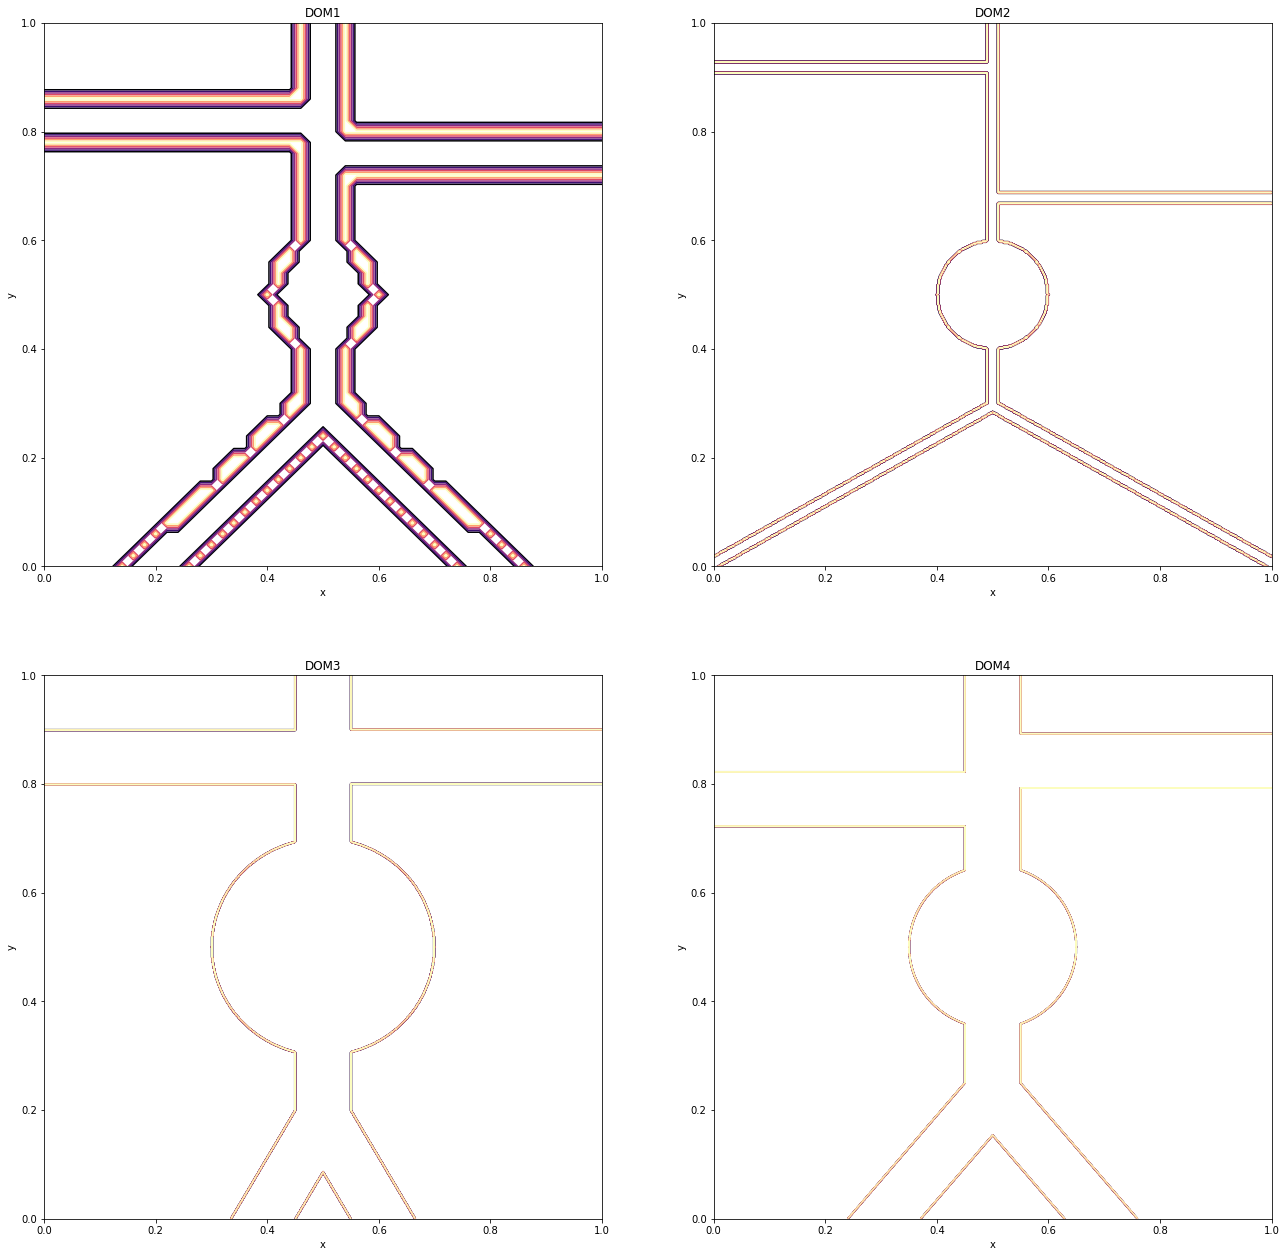

In [52]:
DOM1 = Dom_init(50,2,0.1,40,60,0.1,45)
DOM2 = Dom_init(500,5,0.1,20,80,0.1,60)
DOM3 = Dom_init(1000,50,0.2,50,50,0.1,30)
DOM4 = Dom_init(2000,100,0.15,65,45,0.1,40)

fig = plt.figure(figsize = [22,22])

#DOM1
ax = fig.add_subplot(221)
x = np.linspace(0,1,51)
y = np.linspace(0,1,51)
X,Y = np.meshgrid(x,y)
ax.contour(X,Y,DOM1, cmap = 'magma')
plt.xlabel("x")
plt.ylabel("y")
plt.title("DOM1")

#DOM2
ax = fig.add_subplot(222)
x = np.linspace(0,1,501)
y = np.linspace(0,1,501)
X,Y = np.meshgrid(x,y)
ax.contour(X,Y,DOM2, cmap = 'magma')
plt.xlabel("x")
plt.ylabel("y")
plt.title("DOM2")

#DOM3
ax = fig.add_subplot(223)
x = np.linspace(0,1,1001)
y = np.linspace(0,1,1001)
X,Y = np.meshgrid(x,y)
ax.contour(X,Y,DOM3, cmap = 'magma')
plt.xlabel("x")
plt.ylabel("y")
plt.title("DOM3")

#DOM4
ax = fig.add_subplot(224)
x = np.linspace(0,1,2001)
y = np.linspace(0,1,2001)
X,Y = np.meshgrid(x,y)
ax.contour(X,Y,DOM4, cmap = 'magma')
plt.xlabel("x")
plt.ylabel("y")
plt.title("DOM4")
plt.show()

Pour la suite nous aurons besoin du "masque" de ce domaine, c'est à dire une matrice qui vaut 0 partout sauf à l'intérieur du domaine. Nous obtenons le code suivant, avec les mêmes paramètres.

In [53]:
def masque(N, ray_tub, R, Hg, Hd, Lb, angle):
    """Retourne le masque du domaine i.e un domaine avec des 0 partout sauf à l'intérieur"""

    #Définition du maillage. On choisit de découper le segment [0,1] en N intervalles. Ce qui donne un problème de taille (N+1)*(N+1).
    #Prendre de préférence un N pair (pour assurer (N/2) entier)
    
    x = np.linspace(0,1,N+1)
    y = np.linspace(0,1,N+1)   

    MAT = np.zeros((N+1,N+1))

    # Construction du "sac anévrismal" centré dans le maillage et de rayon R. Ici on part du centre du maillage et on parcourt les points dans le cadran inférieur gauche.
    # On détermine les points du cercle selon la méthode suivante : si un point est dans le cercle et que celui en dessous OU à gauche est à l'extérieur alors c'est un point frontière.
    # On retire les 0 en faisant une boucle if elif
    # On complète par symétrie pour les autres cadrans.
   
    i = int(N/2)
    j = int(N/2)
    
    while (x[i]-0.5)**2 + (y[j]-0.5)**2 <= R**2:
        while (x[i]-0.5)**2 + (y[j]-0.5)**2 <= R**2:
            MAT[i][j] = 1
            MAT[N-i][N-j] = 1
            MAT[i][N-j] = 1
            MAT[N-i][j] = 1
            j = j-1
        i = i-1
        j = int (N/2)
    
    # Construction de l'artère verticale "haute" de rayon d.
    j = N
    i = int(N/2)
    
    while (x[i-ray_tub]-0.5)**2 + (y[j]-0.5)**2 >= R**2:
        for k in range(ray_tub + 1):
            MAT[j][i-k] = 1
            MAT[j][i+k] = 1
        j = j-1
    
    #Construction de l'artère horizontale gauche "haute" repérée grâce au paramètre Hg (pourcentage avec 5 en haut et 95 en bas) de rayon d.
    #On retire également les 0.
    
    y_g = 1 - (0.5-R)*Hg/100
    k = N
    
    while y[k] >= y_g :
        k = k - 1
    
    for i in range(int(N/2)-ray_tub + 1):
        for j in range(ray_tub + 1):
            MAT[k-j][i] = 1
            MAT[k+j][i] = 1

    #Construction de l'artère horizontale droite "haute" repéré grâce au paramètre Hd (compris entre 5 (tout en haut) et 95 (tout en bas)) de rayon d.
    #On parcourt en "sens inverse" i.e en partant de la droite d'où la valeur N-i.
    #On retire également les 0.
    
    y_d = 1-(0.5-R)*Hd/100
    k = N
    
    while y[k] > y_d :
        k = k - 1
    
    for i in range(int(N/2) - ray_tub + 1):
        for j in range(ray_tub + 1):
            MAT[k-j][N-i] = 1
            MAT[k+j][N-i] = 1

    #Construction de l'artère verticale "basse" de rayon d et de longueur Lb.
    j = 0
    i = int(N/2)
    
    while (x[i-ray_tub]-0.5)**2 + (y[j]-0.5)**2 > R**2:
        for k in range(ray_tub + 1):
            if y[j] >= 0.5 - R - Lb :
                MAT[j][i-k] = 1
                MAT[j][i+k] = 1
        j=j+1
        

    #Construction des artères obliquent d'angle "angle" (degré compris entre 5 et 85) par rapport à la verticale x = N/2

    i = int(N/2)- ray_tub
    j = 0

    théta = (angle*pi)/180
    while MAT[j][i] == 0:
        j = j + 1
        
    b = y[j] - np.tan(pi/2 - théta)*x[i]
    a = np.tan(pi/2 - théta)

    for i in range(int(N/2)+1):
        for k in range(j+1):
            if a*x[i] + b >= y[k]:
                MAT[k][i] = 1
                MAT[k][N-i] = 1


    Y_1 = a*x[int(N/2)]+b
    Y_2 = Y_1 - ray_tub*2/(N*np.sin(théta))

    b_2 = Y_2 - a*0.5

    for i in range(int(N/2)+1):
        for k in range(j+1):
            if a*x[i] + b_2 >= y[k]:
                MAT[k][i] = 0
                MAT[k][N-i] = 0
    
    return MAT

De la même manière que pour le domaine inital, on affiche le masque avec les mêmes paramètres.

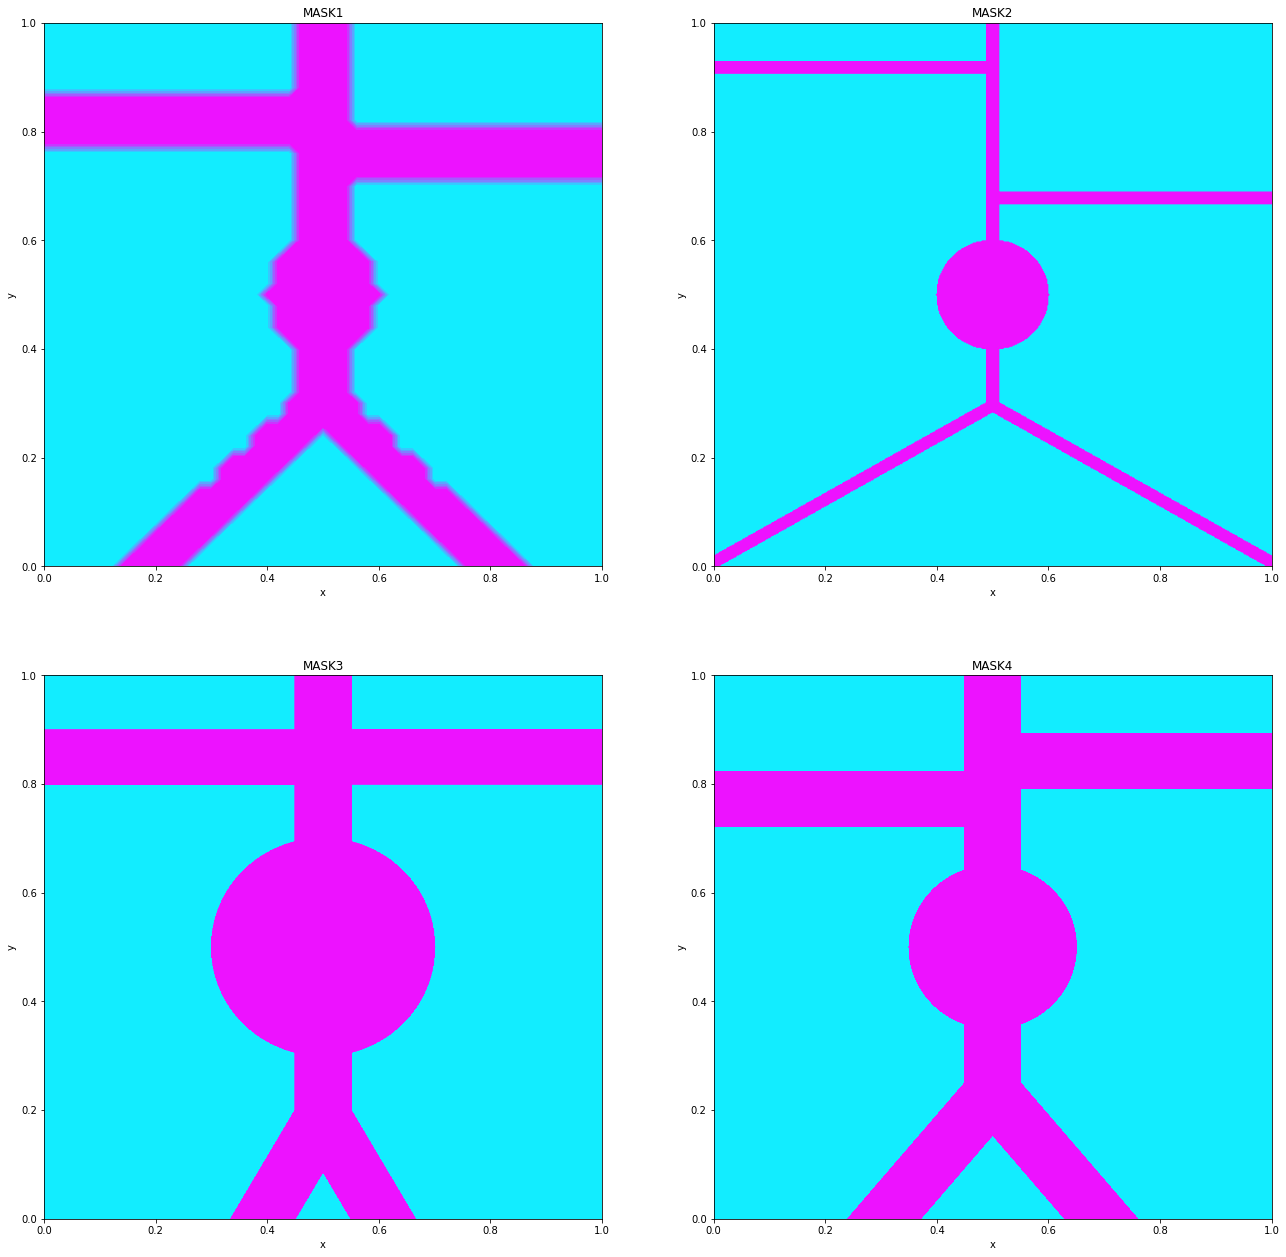

In [54]:
MASK1 = masque(50,2,0.1,40,60,0.1,45)
MASK2 = masque(500,5,0.1,20,80,0.1,60)
MASK3 = masque(1000,50,0.2,50,50,0.1,30)
MASK4 = masque(2000,100,0.15,65,45,0.1,40)

fig = plt.figure(figsize = [22,22])

#DOM1
ax = fig.add_subplot(221)
x = np.linspace(0,1,51)
y = np.linspace(0,1,51)
X,Y = np.meshgrid(x,y)
ax.contourf(X,Y,MASK1, cmap = 'cool')
plt.xlabel("x")
plt.ylabel("y")
plt.title("MASK1")

#DOM2
ax = fig.add_subplot(222)
x = np.linspace(0,1,501)
y = np.linspace(0,1,501)
X,Y = np.meshgrid(x,y)
ax.contourf(X,Y,MASK2, cmap = 'cool')
plt.xlabel("x")
plt.ylabel("y")
plt.title("MASK2")

#DOM3
ax = fig.add_subplot(223)
x = np.linspace(0,1,1001)
y = np.linspace(0,1,1001)
X,Y = np.meshgrid(x,y)
ax.contourf(X,Y,MASK3, cmap = 'cool')
plt.xlabel("x")
plt.ylabel("y")
plt.title("MASK3")

#DOM4
ax = fig.add_subplot(224)
x = np.linspace(0,1,2001)
y = np.linspace(0,1,2001)
X,Y = np.meshgrid(x,y)
ax.contourf(X,Y,MASK4, cmap = 'cool')
plt.xlabel("x")
plt.ylabel("y")
plt.title("MASK4")
plt.show()

## Calcul de la fonction distance sur la géométrie

### Méthode 1 : Utilisation de l'équation de la chaleur

Nous allons coder la fonction distance relatif aux domaines ci-dessus. Nous reprenons les éléments vus lors du cours Groupe Thématique de Travail, cours suivi à l'Université de Bordeaux sous la tutelle de Monsieur * (disponible et détaillée sur notre page Github sous le nom GTT). Pour cela nous avons besoin de la matrice de discrétisation du Laplacien. Nous importons les packages relatifs aux matrices sparses.

In [57]:
import scipy.sparse as sparse
from scipy.sparse import bmat

In [58]:
def matrix_lap2(N,dt):
    """Retourne une matrice qui discrétise le laplacien de u dans le domaine Omega = [xmin,xmax,ymin,ymax]
    découpé en N intervalles en x et y. La matrice finale est une matrice scipy.sparse CSR matrix. 
    Cette matrice est de taille (N+1)*(N+1)"""

    h = 1./N
    h2 = h*h

    #On note les inconnues de 0 à Nx suivant x et 0 à Ny suivant y. 
    #La taille du problème est donc (Nx+1)*(Ny+1).

    #Cela correspond à x_i = i*h et y_j = j*h et la numérotation (i,j) --> k := (N+1)*j+i.

    taille = (1+N)*(1+N)

    diags = np.zeros((5,taille))

    #Diagonale principale
    diags[2,:] = 1.
    diags[2, N+2:taille - (N+2)] = 1 + ((4*dt)/h2)
    diags[2, np.arange(2*N+1, taille, N+1)] = 1.
    diags[2, np.arange(2*N+2, taille, N+1)] = 1.
              
    #Diagonale "-1"
    diags[1,N+1:taille-(N+1)] = -dt/h2
    diags[1, np.arange(2*N, taille, N+1)] = 0.
    diags[1, np.arange(2*N+1, taille, N+1)] = 0.
    
    #Diagonale "+1"
    diags[3, N+3:taille-(N+1)] = -dt/h2
    diags[3, np.arange(2*N+2, taille, N+1)] = 0.
    diags[3, np.arange(2*N+3, taille, N+1)] = 0.

    #Diagonale "-(N+1)"
    diags[0, 1 : taille - (2*N+3)] = -dt/h2
    diags[0, np.arange(N,taille,N+1)] = 0.
    diags[0, np.arange(N+1,taille,N+1)] = 0.

    #Diagonale "+(N+1)"
    diags[4, taille - N*N + 2 : taille - 1] = -dt/h2
    diags[4, np.arange(taille - N*N + 1 + N ,taille,N+1)] = 0.
    diags[4, np.arange(taille - N*N + 2 + N ,taille,N+1)] = 0.

    #Construction de la matrice creuse
    A = sparse.spdiags(diags,[-(N+1),-1,0,1,(N+1)],taille,taille, format = "csr")

    return A

Puis on créé le code pour la fonction distance.

In [59]:
def chaleurdist(MAT,N,dt):
    """Retourne la matrice représentant la fonction distance relative à la géométrie MAT,
    au nombre de points de discrétisation N et à la précision temporelle dt du schéma"""

    taille = (N+1)*(N+1)

    T = np.ones(taille)
    
    for i in range(1,N):
        for j in range(1,N):
            k = i*(N+1) + j
            T[k] = MAT[i][j]

    D = sci.spsolve(matrix_lap2(N,dt), T)
    
    dist = -np.log(D)*np.sqrt(dt)
         
    return dist

Affichons pour les 3 premiers domaines du début leur fonction distance (le 4ème, pour un N = 2000, est un peu violent pour notre pauvre ordinateur!). Nous prendrons un $\delta t$ d'une valeur de $10^{-7}$.

In [77]:
DIST1 = chaleurdist(DOM1,50,0.0000001)
DIST2 = chaleurdist(DOM2,500,0.0000001)
DIST3 = chaleurdist(DOM3,1000,0.0000001)

Text(0.5,0.92,'DIST3')

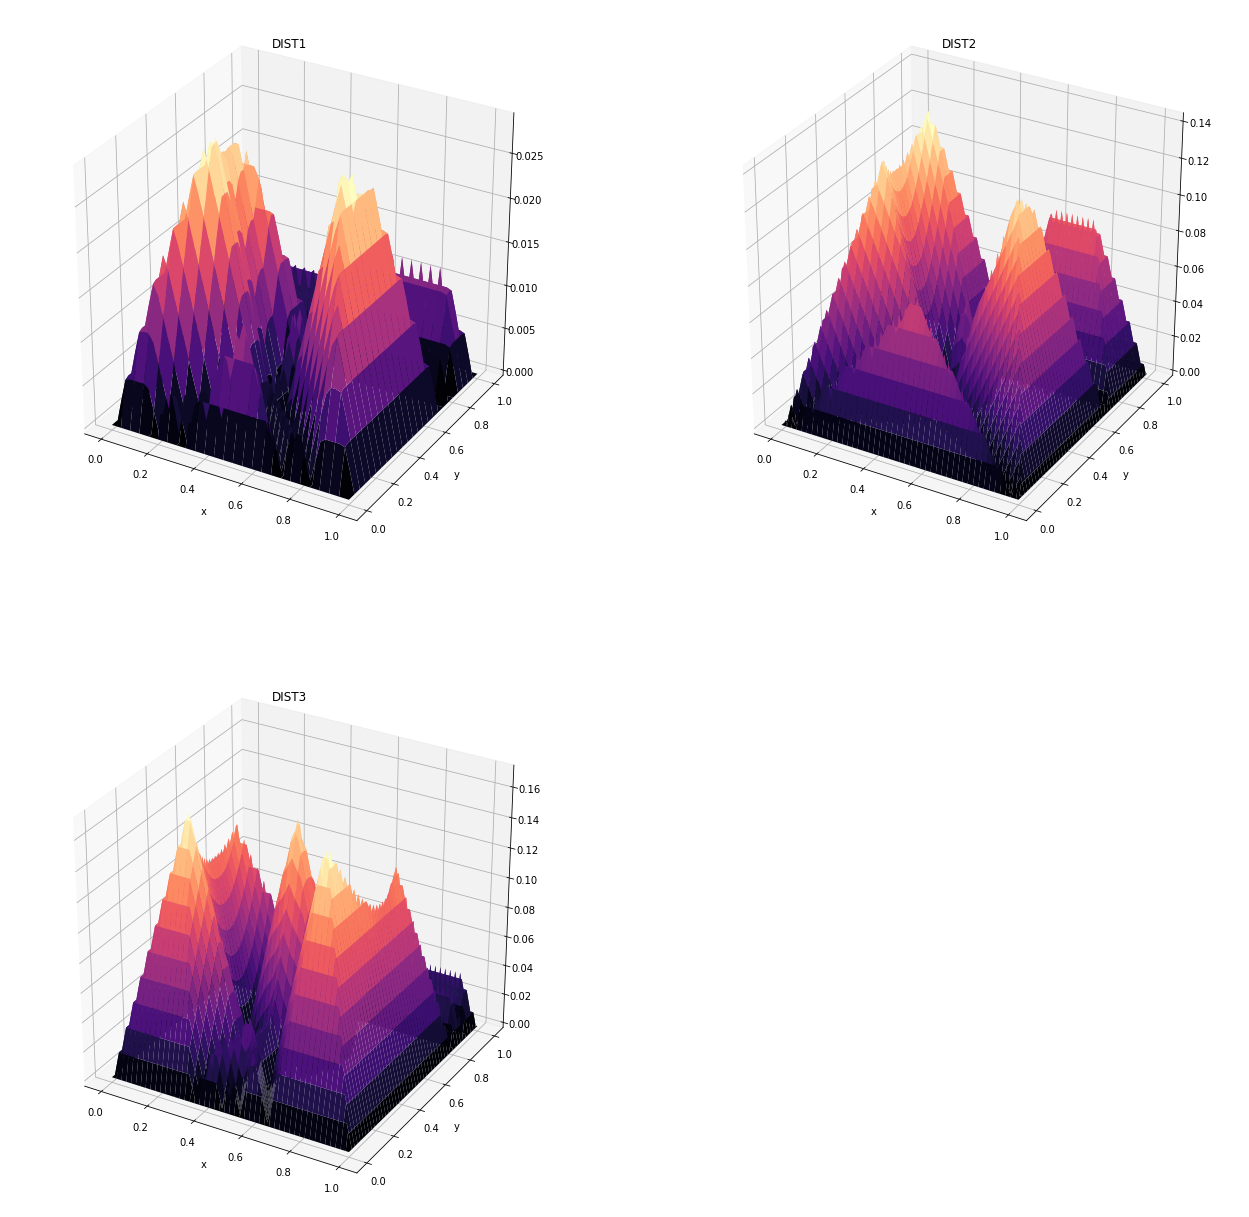

In [79]:
fig = plt.figure(figsize = [22,22])

#DIST1
ax = fig.add_subplot(221, projection = '3d')
x = np.linspace(0,1,51)
y = np.linspace(0,1,51)
X,Y = np.meshgrid(x,y)
ax.plot_surface(X,Y,DIST1.reshape(51,51), cmap = 'magma')
plt.xlabel("x")
plt.ylabel("y")
plt.title("DIST1")

#DOM2
ax = fig.add_subplot(222, projection = '3d')
x = np.linspace(0,1,501)
y = np.linspace(0,1,501)
X,Y = np.meshgrid(x,y)
ax.plot_surface(X,Y,DIST2.reshape(501,501), cmap = 'magma')
plt.xlabel("x")
plt.ylabel("y")
plt.title("DIST2")

#DOM3
ax = fig.add_subplot(223, projection = '3d')
x = np.linspace(0,1,1001)
y = np.linspace(0,1,1001)
X,Y = np.meshgrid(x,y)
ax.plot_surface(X,Y,DIST3.reshape(1001,1001), cmap = 'magma')
plt.xlabel("x")
plt.ylabel("y")
plt.title("DIST3")

AFFICHER LES GRAPHIQUES PAR FICHIERS IMAGES CAR SINON C EST NUL

Nous allons effectuer une pénalisation pour ne garder que la fonction distance dans le domaine. D'où l'intérêt du masque créé en début de ce document.

In [70]:
def penalisation(DIST, MASK, N):

    PENAL = MASK*DIST.reshape(N+1,N+1)

    return PENAL

In [73]:
PENAL1 = penalisation(DIST1,MASK1,50)
PENAL2 = penalisation(DIST2,MASK2,500)
PENAL3 = penalisation(DIST3,MASK3,1000)

Text(0.5,0.92,'PENAL3')

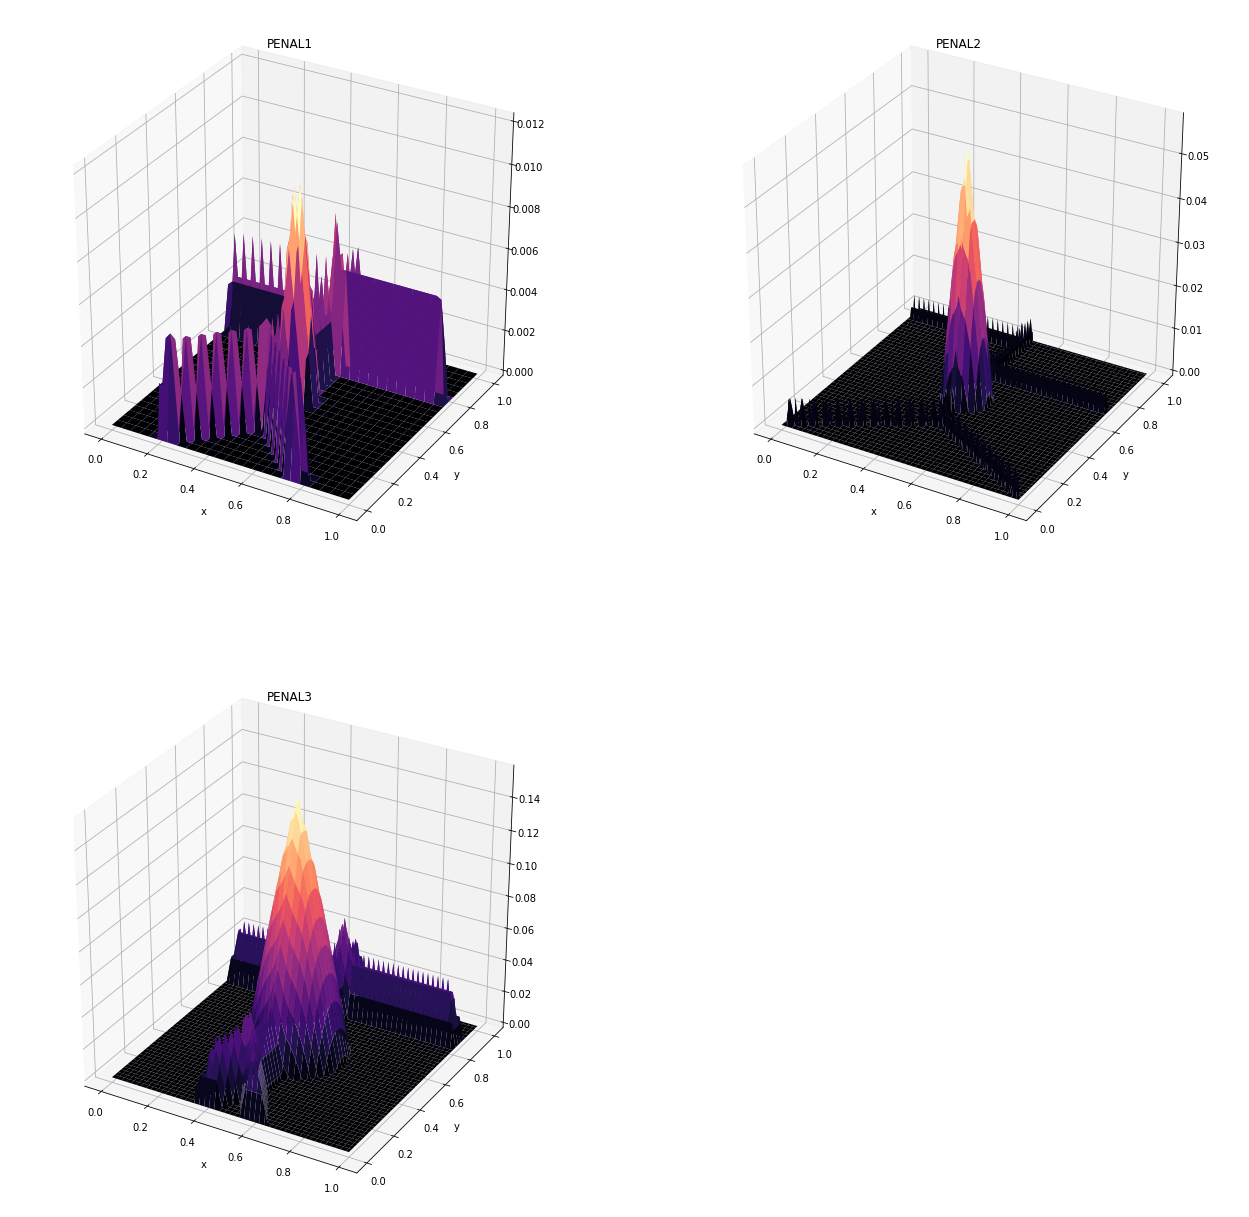

In [80]:
fig = plt.figure(figsize = [22,22])

#DOM1
ax = fig.add_subplot(221, projection = '3d')
x = np.linspace(0,1,51)
y = np.linspace(0,1,51)
X,Y = np.meshgrid(x,y)
ax.plot_surface(X,Y,PENAL1, cmap = 'magma')
plt.xlabel("x")
plt.ylabel("y")
plt.title("PENAL1")

#DOM2
ax = fig.add_subplot(222, projection = '3d')
x = np.linspace(0,1,501)
y = np.linspace(0,1,501)
X,Y = np.meshgrid(x,y)
ax.plot_surface(X,Y,PENAL2, cmap = 'magma')
plt.xlabel("x")
plt.ylabel("y")
plt.title("PENAL2")

#DOM3
ax = fig.add_subplot(223, projection = '3d')
x = np.linspace(0,1,1001)
y = np.linspace(0,1,1001)
X,Y = np.meshgrid(x,y)
ax.plot_surface(X,Y,PENAL3, cmap = 'magma')
plt.xlabel("x")
plt.ylabel("y")
plt.title("PENAL3")

AFFICHER LES GRAPHIQUES PAR FICHIERS IMAGES PARCE QUE LA C EST DE LA MERDE

### Méthode 2 : Le Fast-Marching